In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timezone, datetime,date

import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from yellowbrick.regressor import PredictionError
import pytz
from functools import reduce


plt.style.use('fivethirtyeight')
%matplotlib inline

pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')



In [19]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [20]:
fre = './Data/Bike_Counts/Fremont_Bridge.csv'
fremont = pd.read_csv(fre,parse_dates = [0],index_col='Date')

fremont.rename(columns = {'Fremont Bridge East Sidewalk' : 'EastSide',
                         'Fremont Bridge West Sidewalk':'WestSide',
                         'Date':'Date_Join'} , inplace= True)


fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
fremont_d = fremont.resample('D').sum()
fremont_d.index.names = ['Date_Join']
fremont_d.head(10)

,EastSide,WestSide
Date_Join,,
2012-10-03 00:00:00-07:00,1760.0,1761.0
2012-10-04 00:00:00-07:00,1708.0,1767.0
2012-10-05 00:00:00-07:00,1558.0,1590.0
2012-10-06 00:00:00-07:00,1080.0,926.0
2012-10-07 00:00:00-07:00,1191.0,951.0
2012-10-08 00:00:00-07:00,1829.0,1708.0
2012-10-09 00:00:00-07:00,1759.0,1742.0
2012-10-10 00:00:00-07:00,1648.0,1587.0
2012-10-11 00:00:00-07:00,1579.0,1468.0


In [21]:
path = "./Data/Daily_Summaries/Daily_Summaries_Merged.csv"
d = ","
wx = pd.read_csv(path,delimiter=d)
wx.DATE = pd.to_datetime(wx.DATE)
wx.rename(columns={'DATE':'Date_Join'},inplace = True)
#wx["Season"] = wx['Date_Join'].apply(get_season)
#wx.drop(['LATITUDE','LONGITUDE'],axis = 1,inplace=True);

In [22]:
wx.loc[wx['STATION'] == 'USW00024233', 'NAME'] = 'SeaTac'
wx.loc[wx['STATION'] == 'USW00024234', 'NAME'] = 'Boeing_Field'
wx.loc[wx['STATION'] == 'US1WAKG0079', 'NAME'] = 'Magnolia'
wx.loc[wx['STATION'] == 'US1WAKG0145', 'NAME'] = 'Phinney'
wx.loc[wx['STATION'] == 'US1WAKG0200', 'NAME'] = 'Georgetown'
wx.loc[wx['STATION'] == 'US1WAKG0199', 'NAME'] = 'GreenWood'
wx.loc[wx['STATION'] == 'US1WAKG0225', 'NAME'] = 'Cap_Hill'
wx.loc[wx['STATION'] == 'US1WAKG0239', 'NAME'] = 'Woodland_Park'


In [23]:
wx_d = wx.groupby(by = 'Date_Join')[['PRCP','TMAX','TMIN']].mean()
wx_d = wx_d.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
wx_d['Season']=wx_d.index.to_series().apply(get_season)

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
wx_d.sort_values(by='PRCP',ascending=False)

,PRCP,TMAX,TMIN,Season
Date_Join,,,,
2010-12-12 00:00:00-08:00,2.410000,57.0,49.5,Autumn
2017-01-18 00:00:00-08:00,1.850000,53.0,44.0,Winter
2017-02-09 00:00:00-08:00,1.732000,56.5,39.5,Winter
2012-11-19 00:00:00-08:00,1.637500,56.5,47.0,Autumn
2016-10-14 00:00:00-07:00,1.618333,58.5,50.5,Autumn
2018-11-27 00:00:00-08:00,1.583750,58.5,48.5,Autumn
2015-12-08 00:00:00-08:00,1.555000,61.5,51.0,Autumn
2014-03-05 00:00:00-08:00,1.550000,60.5,51.0,Winter
2012-11-30 00:00:00-08:00,1.455000,59.0,46.0,Autumn


In [25]:
wx_d = pd.get_dummies(data=wx_d, columns = ['Season'])

In [26]:
data = fremont_d.merge(wx_d, how = 'inner',left_on = 'Date_Join',right_on = 'Date_Join')
data['Mean_Xing'] = data[['EastSide','WestSide']].mean(axis=1)
#data.head()

In [27]:
null_df = pd.DataFrame(data.isnull().sum().sort_values(ascending=False),columns=['Null_Count'])
null_df[null_df['Null_Count'] >0]

,Null_Count


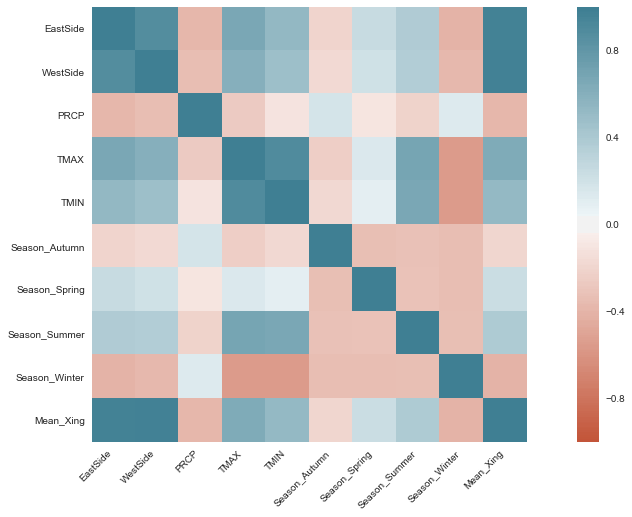

In [28]:
plt.rcParams['figure.figsize'] = (16, 8)
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [29]:
corr['Mean_Xing'].sort_values(ascending=False).tail(20)

Mean_Xing        1.000000
WestSide         0.974717
EastSide         0.961195
TMAX             0.648213
TMIN             0.516032
Season_Summer    0.378443
Season_Spring    0.231110
Season_Autumn   -0.193801
PRCP            -0.377053
Season_Winter   -0.398946
Name: Mean_Xing, dtype: float64

In [30]:
#baseline Accuracy
[data.Mean_Xing.mean()]* 5

[1323.1149521032903,
 1323.1149521032903,
 1323.1149521032903,
 1323.1149521032903,
 1323.1149521032903]

In [31]:
features = ['PRCP','TMAX','TMIN','Season_Summer','Season_Spring','Season_Autumn','Season_Winter']
X = data[features]
y = data['Mean_Xing']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state= 23)
#y_test=pd.DataFrame(y_test)
#y_train=pd.DataFrame(y_train)

y_baseline = [data.Mean_Xing.mean()] * len(y_test)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)
print(len(y_baseline))

(1800, 7)
(1800,)
(601, 7)
(601,)
601


In [32]:
#X_train.sample(15)#DF Index
#X_test.sample(15)#DF Index
#y_test.sample(15)# Index
#y_train.sample(15)# Index

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train,columns = features,index=y_train.index)
X_test = pd.DataFrame(X_test,columns = features,index=y_test.index)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1800, 7)
(1800,)
(601, 7)
(601,)


C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
#X_train.sample(15) #DF Index
#X_test.sample(15) #DF Index
#y_test.sample(15) # Index
#y_train.sample(15) # Index

In [37]:
#fit the model
#model = Lasso(alpha=100)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#y_pred= pd.DataFrame(y_pred,index=y_test.index,columns = ['Predicted_Xing'] )
print("R-squared = ", model.score(X_test, y_test)) 
print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Baseline RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_baseline)))


R-squared =  0.4290690511234664
RMSE =  493.9604114480309
Baseline RMSE =  653.7651456929499


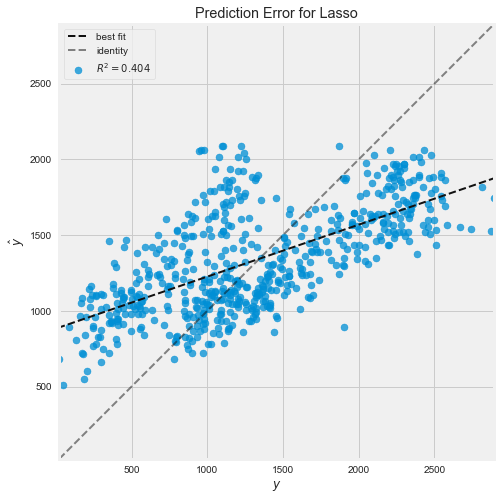

In [58]:
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

plt.rcParams['figure.figsize'] = (16, 8)

visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

#plt.scatter(y_test,y_pred)
#plt.xlabel('True Values')
#plt.ylabel('Predictions')

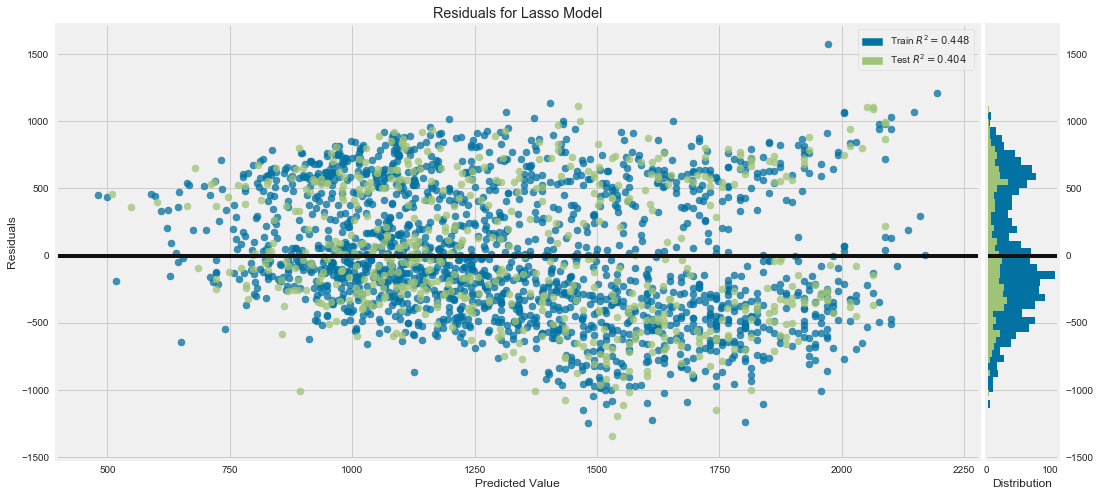

In [59]:
plt.rcParams['figure.figsize'] = (16, 8)

visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [61]:

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, model.coef_[idx]))
#list(zip(features, linreg.coef_))
print("R-squared = ", model.score(X_test, y_test))  
print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Baseline_RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_baseline)))

The coefficient for PRCP is -77.66544379146826
The coefficient for TMAX is 309.35155080261546
The coefficient for TMIN is 0.0
The coefficient for Season_Summer is 0.0
The coefficient for Season_Spring is 0.0
The coefficient for Season_Autumn is -0.0
The coefficient for Season_Winter is -0.0
R-squared =  0.40429148739047926
RMSE =  504.5651536404793
Baseline_RMSE =  653.7651456929499


In [62]:
y_test=pd.DataFrame(y_test)
y_train=pd.DataFrame(y_train)

In [63]:
#X_train.sample(15)#DF
#X_test.sample(15)#DF
#y_test.sample(15)
#y_train.sample(15)#DF Index
#y_pred.sample(15)#DF Index

In [64]:
dfs = (X_test,y_test,y_pred)

results = reduce(lambda left,right: pd.merge(left,right,on = 'Date_Join'),dfs)
results['DIF'] = abs(results['Mean_Xing'] - results['Predicted_Xing'])

#X_test.head()
#y_pred
#y_test
results.sort_values(by = 'DIF',ascending= False).head(20)

,PRCP,TMAX,TMIN,Season_Summer,Season_Spring,Season_Autumn,Season_Winter,Mean_Xing,Predicted_Xing,DIF
Date_Join,,,,,,,,,,
2014-05-16 00:00:00-07:00,-0.535926,0.526578,0.751634,-0.539674,1.739783,-0.60131,-0.593605,2871.0,1529.803061,1341.196939
2018-05-15 00:00:00-07:00,-0.535926,0.564967,0.751634,-0.539674,1.739783,-0.60131,-0.593605,2739.5,1541.678949,1197.821051
2018-05-22 00:00:00-07:00,-0.535926,1.217591,0.539491,-0.539674,1.739783,-0.60131,-0.593605,2893.5,1743.569040,1149.930960
2018-05-02 00:00:00-07:00,-0.528448,0.603357,-0.256045,-0.539674,1.739783,-0.60131,-0.593605,2666.0,1552.974054,1113.025946
2015-08-29 00:00:00-07:00,1.886948,0.910474,0.751634,1.852970,-0.574784,-0.60131,-0.593605,349.5,1460.388286,1110.888286
2016-08-13 00:00:00-07:00,-0.535926,2.215721,1.865384,1.852970,-0.574784,-0.60131,-0.593605,945.5,2052.342119,1106.842119
2015-07-05 00:00:00-07:00,-0.535926,2.254110,1.865384,1.852970,-0.574784,-0.60131,-0.593605,959.5,2064.218007,1104.718007
2016-08-20 00:00:00-07:00,-0.535926,2.254110,1.600205,1.852970,-0.574784,-0.60131,-0.593605,975.5,2064.218007,1088.718007
2013-05-01 00:00:00-07:00,-0.535926,0.219461,-0.945509,-0.539674,1.739783,-0.60131,-0.593605,2508.5,1434.795960,1073.704040
